In [ ]:
!pip install kfp torch matplotlib docker sklearn dill kubernetes dvc

In [1]:
%load_ext autoreload
%autoreload 2
import kfp
import os
from kfp.dsl import ContainerOp, ResourceOp
import torch
import numpy as np
import matplotlib.pyplot as plt
import docker
import shutil
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from collections import namedtuple
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import warnings
from kfp.dsl import pipeline, ContainerOp
from kfp import Client
from kubernetes import client as k8s
from urllib3.connection import SubjectAltNameWarning
from typing import Optional, List, Tuple, Dict
from kfp.dsl import InputArgumentPath
from textwrap import dedent

# Prerequisites
Before we can start we, obviously, need to gather our data and check if it fits our needs. Additionally 
we might want to consider applying any preprocessing procedures, if required. The process of analyzing and 
cleaning data is often called data munging and represents a significant (and important) part of any data scientists
work. Besides cleaning up our data, we want to check which model might be suitable for our needs. Let's start with some 
local runs of the procedures before moving our calculations to the actual kubernetes cluster!

## Getting the Data and Data Munging
Because it's easy to understand, we will use the MNIST-dataset, which consists of various image of handwritten numbers. 
We can easily gather this dataset from multiple sources, for example directly from scikit-learn:

In [2]:
# The MNIST dataset
digits = datasets.load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
digits.images[0], digits.target[0]

(array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
        [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
        [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
        [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
        [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
        [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
        [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
        [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]]),
 0)

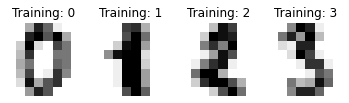

In [4]:
_, axes = plt.subplots(1, 4)
images_and_labels = list(zip(digits.images, digits.target))

for ax, (image, label) in zip(axes, images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

Let's see how much images we have in total

In [5]:
digits.images.shape

(1797, 8, 8)

Let's center and standardize the images by their statistics (mean and standard deviation):

In [6]:
def equalize_images(images: np.ndarray) -> np.ndarray:
    mean = images.mean()
    std = images.std()
    return (images - mean)/std

images = equalize_images(digits.images)

Additionally, as we have around 1800 (very tiny) images of a scale of 8x8 pixels we can easily create 6 sub datasets,
as required models will have only a few parameters and thus overfitting should be no problem. To create the sub datasets (folds), 
we will make use of the stratified K-Fold method. This will create 6 datasets with a fix percentage of training and validation
images and an equal distribution with respect to their target (labels).

In [7]:
fold = namedtuple("Fold", ["X", "y"])
dataset = namedtuple("Dataset", ["train", "test"])

def make_cross_folds(digits: np.ndarray, labels: np.ndarray, amount: int) -> dataset:
    skf = StratifiedKFold(n_splits=amount)
    folds = []
    
    for train_index, test_index in skf.split(digits, labels):
        X_train, X_test = digits[train_index], digits[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        train_fold = fold(X_train, y_train)
        test_fold = fold(X_test, y_test)
        folds.append(dataset(train_fold, test_fold))
    return folds

cross_folds = make_cross_folds(images, digits.target, 6)

In [8]:
for i in range(6):
    print("Set {}: training images shape: {}".format(i, cross_folds[i].train.X.shape))
    print("Set {}: test images shape: {}".format(i, cross_folds[i].test.X.shape))
    print("Set {}: training labels shape: {}".format(i,  cross_folds[i].train.y.shape))
    print("Set {}: test labels shape: {}".format(i, cross_folds[i].test.y.shape))

Set 0: training images shape: (1497, 8, 8)
Set 0: test images shape: (300, 8, 8)
Set 0: training labels shape: (1497,)
Set 0: test labels shape: (300,)
Set 1: training images shape: (1497, 8, 8)
Set 1: test images shape: (300, 8, 8)
Set 1: training labels shape: (1497,)
Set 1: test labels shape: (300,)
Set 2: training images shape: (1497, 8, 8)
Set 2: test images shape: (300, 8, 8)
Set 2: training labels shape: (1497,)
Set 2: test labels shape: (300,)
Set 3: training images shape: (1498, 8, 8)
Set 3: test images shape: (299, 8, 8)
Set 3: training labels shape: (1498,)
Set 3: test labels shape: (299,)
Set 4: training images shape: (1498, 8, 8)
Set 4: test images shape: (299, 8, 8)
Set 4: training labels shape: (1498,)
Set 4: test labels shape: (299,)
Set 5: training images shape: (1498, 8, 8)
Set 5: test images shape: (299, 8, 8)
Set 5: training labels shape: (1498,)
Set 5: test labels shape: (299,)


Finally we will place all our created methods inside our training script

In [118]:
!python ../src/main.py preprocess --out "dump"

/home/mbu93/Projects/visum-talk/notebooks
Set 0: training images shape: (1497, 8, 8)
Set 0: test images shape: (300, 8, 8)
Set 0: training labels shape: (1497,)
Set 0: test labels shape: (300,)
Set 1: training images shape: (1497, 8, 8)
Set 1: test images shape: (300, 8, 8)
Set 1: training labels shape: (1497,)
Set 1: test labels shape: (300,)
Set 2: training images shape: (1497, 8, 8)
Set 2: test images shape: (300, 8, 8)
Set 2: training labels shape: (1497,)
Set 2: test labels shape: (300,)
Set 3: training images shape: (1498, 8, 8)
Set 3: test images shape: (299, 8, 8)
Set 3: training labels shape: (1498,)
Set 3: test labels shape: (299,)
Set 4: training images shape: (1498, 8, 8)
Set 4: test images shape: (299, 8, 8)
Set 4: training labels shape: (1498,)
Set 4: test labels shape: (299,)
Set 5: training images shape: (1498, 8, 8)
Set 5: test images shape: (299, 8, 8)
Set 5: training labels shape: (1498,)
Set 5: test labels shape: (299,)


## Model Selection
One of the most challenging tasks when building a machine learning model is finding a suitable model. This
selection process typically requires a lot of theoretical basic knowledge and practical experience in order 
not to be extremely time consuming. Let's for a moment keep it simple and compare 3 possible models, namely:
- A Linear Regression
- B Support Vector Machine
- C Nearest Neighbors

We will see later how kubernetes may help us with this task

In [9]:
lin_reg = LinearRegression()
svm_clf = svm.SVC(gamma=0.01)
nearest_neighbor = KNeighborsClassifier(125)
ds = cross_folds[0]

lin_reg.fit(ds.train.X.reshape(-1, 8*8), ds.train.y)
lin_reg_score = lin_reg.score(ds.test.X.reshape(-1, 8*8), ds.test.y)

svm_clf.fit(ds.train.X.reshape(-1, 8*8), ds.train.y)
svm_score = svm_clf.score(ds.test.X.reshape(-1, 8*8), ds.test.y)

nearest_neighbor.fit(ds.train.X.reshape(-1, 8*8), ds.train.y)
nearest_neighbor_score = nearest_neighbor.score(ds.test.X.reshape(-1, 8*8), ds.test.y)

lin_reg_score, svm_score, nearest_neighbor_score

(0.4220325389111206, 0.96, 0.8833333333333333)

In [10]:
(confusion_matrix(ds.test.y, lin_reg.predict(ds.test.X.reshape(-1, 8*8)).astype('int')),
confusion_matrix(ds.test.y, svm_clf.predict(ds.test.X.reshape(-1, 8*8))),
confusion_matrix(ds.test.y, nearest_neighbor.predict(ds.test.X.reshape(-1, 8*8))))

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  7,  8, 10,  3,  0,  0,  0,  0,  0,  0],
        [ 0,  3,  5,  4,  9,  6,  2,  1,  0,  0,  0],
        [ 0,  4,  5, 14,  7,  0,  0,  0,  0,  0,  0],
        [ 0,  9, 10,  2,  5,  4,  0,  0,  0,  0,  0],
        [ 0,  1,  1,  4,  5, 12,  6,  2,  0,  0,  0],
        [ 0,  1,  0,  0,  4, 12,  7,  4,  2,  0,  0],
        [ 0,  0,  0,  1,  2, 10, 14,  3,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  6,  9,  9,  5,  1,  0],
        [ 0,  0,  1,  3,  5,  5,  8,  3,  3,  1,  0],
        [ 0,  0,  0,  2,  4,  3,  9,  5,  7,  0,  0]]),
 array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  3, 26,  0,  0,  0,  0,  0,  1,  0],
        [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0, 30,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 29,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0, 30,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 29,  0,  1],
    

## Building a basic container
Our code for training and hyperparameter tuning will run inside a docker container. For that purpose
we need to install the required python dependencies as well as putting some scripts that e.g. will train 
our model into the container.

In [133]:
!bat ../docker/pipeline/requirements.txt

───────┬────────────────────────────────────────────────────────────────────────
       │ File: ../docker/pipeline/requirements.txt
───────┼────────────────────────────────────────────────────────────────────────
   1   │ scikit-learn
   2   │ numpy
   3   │ pandas
   4   │ scikit-image
   5   │ pillow
   6   │ dill
───────┴────────────────────────────────────────────────────────────────────────


In [134]:
!bat ../docker/pipeline/Dockerfile

───────┬────────────────────────────────────────────────────────────────────────
       │ File: ../docker/pipeline/Dockerfile
───────┼────────────────────────────────────────────────────────────────────────
   1   │ FROM python:3.8-slim
   2   │ 
   3   │ ### Setup python requirements
   4   │ COPY requirements.txt .
   5   │ RUN pip install --no-cache-dir --no-use-pep517 -r requirements.txt
   6   │ 
   7   │ # Copy the code
   8   │ COPY main.py .
   9   │ 
  10   │ ENTRYPOINT /bin/bash
───────┴────────────────────────────────────────────────────────────────────────


In [48]:
client = docker.from_env()

In [50]:
IMAGE = "mbu93/visum-pipline-runner:latest"

def create_base_container():
    shutil.copy("../src/main.py", "../docker/pipeline/")
    client.images.build(path="../docker/pipeline/", tag=IMAGE, quiet=False)

def push_image():
    client.images.push(IMAGE)

create_base_container()
push_image()

# Applying the first actions on kubernetes: Preprocessing
To move our code execution to the kubernetes cluster we will use
- The kubeflow pipeline system (which relies on argo)
- Kubeflow's kfp python package as compiler for the pipeline descriptions
- Our docker container as created beforehand

Running our preprocessing step (data downloading and splitting) may look as below.

In [69]:
warnings.filterwarnings("ignore", category=SubjectAltNameWarning)

outpath="/out"

@pipeline(name="preprocessing-step", description="preprocessing step of the VISUM example")
def pipe():
    ctr = ContainerOp(
        image="mbu93/visum-pipeline-runner",
        name="preprocess",
        command=["bash", "-c"],
        arguments="python main.py preprocess --out {}".format(outpath)
    )    
    # Output Artifacts
    vol = "output-artifacts"
    ctr.add_volume(
        k8s.V1Volume(name=vol, empty_dir=k8s.V1EmptyDirVolumeSource()))
    ctr.container.add_volume_mount(
        k8s.V1VolumeMount(name=vol, mount_path=outpath))
    
kfp.Client().create_run_from_pipeline_func(pipe, arguments={})

and results in a pipeline step as below

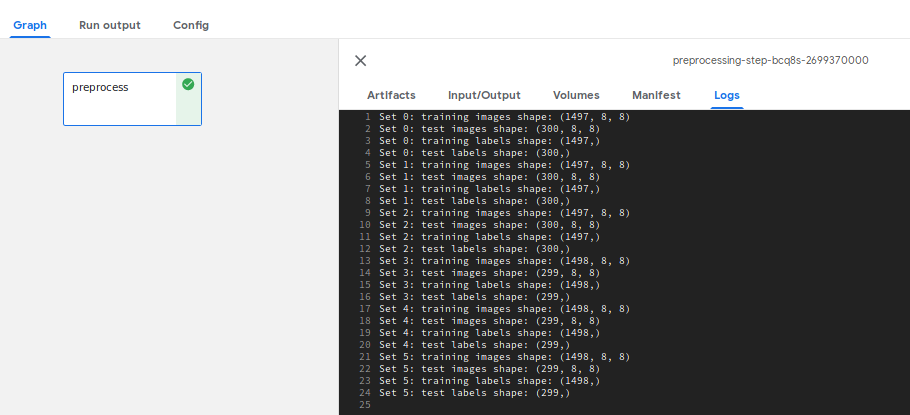

## Kubeflow container wrapper
Additionally to the simple definition we made above, we need a few actions 
to be done by the __Kubeflow Pipeline__ system regularly, which consist in:
- mounting a Volume that transports outputs between singular stages,
- getting input files and folder to the right directing and
- processing the arguments that we want to pass to each container
- getting outputs to the correct location (persistent volume)
We'll write a little convenience method to save some code as below:

In [4]:
BASE_IMAGE = "mbu93/visum-pipeline-runner:latest"
def container(
    name: str,
    arguments: str,
    inputs: Optional[List[Tuple[InputArgumentPath, str]]] = None,
    outputs: Optional[Dict[str, str]] = None,
    image: str = None
) -> Tuple[ContainerOp, Dict[str, Tuple[InputArgumentPath, str]]]:
    # Set the correct shell parameters
    prepare_args = "set -euo pipefail\n"

    # Copy the output artifacts correctly
    file_outputs = {}
    output_artifact_copy_args = ""
    if outputs:
        for k, v in outputs.items():
            out = out_dir(v)
            file_outputs[k] = out
            output_artifact_copy_args += dedent("""
                mkdir -p {d}
                echo copying outputs
                cp -r {fr} {to}
            """.format(
                d=os.path.dirname(out),
                fr=v,
                to=out,
            )).lstrip()

    # Create the container
    ctr = ContainerOp(
        image=BASE_IMAGE if not image else image,
        name=name,
        command=["bash", "-c"],
        output_artifact_paths=default_artifact_path(),
        file_outputs=file_outputs,
        artifact_argument_paths=[InputArgumentPath(x[0])
                                 for x in inputs] if inputs else None,
    )
    ctr.container.set_image_pull_policy("Always")

    # Copy input artifacts correctly
    input_artifact_copy_args = ""
    in_repo = False
    for i, path in enumerate(ctr.input_artifact_paths.values()):
        target_location = inputs[i][1]
        parent = os.path.dirname(target_location)
        if parent:
            input_artifact_copy_args += "mkdir -p {} &&".format(parent)

        input_artifact_copy_args += "cp -r {fr} {to}\n".format(fr=path, to=target_location)


    # Assemble the command
    ctr.arguments = prepare_args + \
        input_artifact_copy_args + \
        arguments + \
        "\n" + \
        output_artifact_copy_args

    # Output Artifacts
    vol = "output-artifacts"
    ctr.add_volume(
        k8s.V1Volume(name=vol, empty_dir=k8s.V1EmptyDirVolumeSource()))
    ctr.container.add_volume_mount(
        k8s.V1VolumeMount(name=vol, mount_path="/out"))


    # Assemble the inputs for the next stage
    consumable_inputs = {}
    for k, v in file_outputs.items():
        consumable_inputs[k] = (ctr.outputs[k], outputs[k])

    return ctr, consumable_inputs

def default_artifact_path() -> Dict[str, str]:
    metadata = "mlpipeline-ui-metadata.json"
    metrics = "mlpipeline-metrics.json"
    return {
        os.path.splitext(metadata)[0]: out_dir(metadata),
        os.path.splitext(metrics)[0]: out_dir(metrics),
    }

def out_dir(path: str) -> str:
    return os.path.join("/out", path)

# Hyperparameter Tuning & Model Selection
As mentioned before, selecting the right model can be crucial to find the best matching solution for our problem. 
There is, however, another important factor considering model selection: picking the right hyperparameters. Let's 
see what happens if we are playing around with our preceeding model

In [23]:
lin_reg = LinearRegression()
svm_clf = svm.SVC(gamma=0.0001)
nearest_neighbor = KNeighborsClassifier(25)
ds = cross_folds[0]

lin_reg.fit(ds.train.X.reshape(-1, 8*8), ds.train.y)
lin_reg_score = lin_reg.score(ds.test.X.reshape(-1, 8*8), ds.test.y)

svm_clf.fit(ds.train.X.reshape(-1, 8*8), ds.train.y)
svm_score = svm_clf.score(ds.test.X.reshape(-1, 8*8), ds.test.y)

nearest_neighbor.fit(ds.train.X.reshape(-1, 8*8), ds.train.y)
nearest_neighbor_score = nearest_neighbor.score(ds.test.X.reshape(-1, 8*8), ds.test.y)

lin_reg_score, svm_score, nearest_neighbor_score

(0.4220325389111206, 0.47333333333333333, 0.93)

Ouch! That was basically blew up our results. What if we hadn't chosen the right parameter in the first place? And did we maybe drop
the other models unjustified, just because we had chosen wrong parameters for them? This is a common question that can be really 
time consuming to answer if we are going to work with data that we have no domain knowledge for. In addition, simply trying out a lot 
of possible combinations can be as anyoing (as we need to set a looooot of parameters) as ressource expensive and thus also take 
quite long. Luckily, with kubernetes we can work against these problems using __Kubeflow Katib__.

## Code
Let's create a training routine which can handle a certain set of flexible model parameters consisting in:
- The model type itself
- [for a svm] the gamma faktor (distance to the bordering line)
- [for a k-nearest-neighbors-classifier] the amount of neighbors

In [61]:
from importlib import import_module
warnings.filterwarnings("ignore", category=FutureWarning)

def tune(gamma, neighbors, model) -> float:
    clf_str = model.split(".")[-1]
    lib = model.replace(clf_str, "")[:-1]
    clf = getattr(import_module(lib), clf_str)

    if clf_str == "SVC":
        clf = clf(gamma)
    elif clf_str == "KNeighborsClassifier":
        clf = clf(neighbors)
    else:
        clf = clf()

    ds = cross_folds[0]
    clf.fit(ds.train.X.reshape(-1, 8 * 8), ds.train.y)
    score = clf.score(ds.test.X.reshape(-1, 8 * 8), ds.test.y)
    print("Epoch 0: \naccuracy={}".format(score))
tune(0.01, 10, "sklearn.svm.SVC")

Epoch 0: 
accuracy=0.11666666666666667


## Kubernetes Ressource
To run a hyperparameter tuning in kubeflow, we need to define our experiment as in the following yaml representation.

In [48]:
!bat ../src/katib.yaml

───────┬────────────────────────────────────────────────────────────────────────
       │ File: ../src/katib.yaml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ apiVersion: "kubeflow.org/v1alpha3"
   2   │ kind: Experiment
   3   │ metadata:
   4   │   namespace: mb18lasy
   5   │   labels:
   6   │     controller-tools.k8s.io: "1.0"
   7   │   name: visum-example
   8   │ spec:
   9   │   objective:
  10   │     type: maximize
  11   │     goal: 0.95
  12   │     objectiveMetricName: accuracy
  13   │   algorithm:
  14   │     algorithmName: random
  15   │   parallelTrialCount: 2
  16   │   maxTrialCount: 12
  17   │   maxFailedTrialCount: 1
  18   │   parameters:
  19   │     - name: --neighbors
  20   │       parameterType: int
  21   │       feasibleSpace:
  22   │         min: "2"
  23   │         max: "150"
  24   │     - name: --gamma
  25   │       parameterType: float
  26   │       feasibleSpace:
  27   │         min: "0.00001"
  28

A __Katib Experiment__, as well as a __Katib Trial__ and a __Katib Suggestion__ is a *custom ressource* which is defined when installing __Katib__ to a kubernetes cluster. This kuberenetes ressource define a set of basic ressources (pods, containers, service etc.) that need to be created when the kubernetes
API gets requested for that certain ressource. A __Katib Experiment__ defines.
- An optimization objective (minimization or maximization of a certain metric)
- An algorithm type for the parameters search (e.g. random, bayesian, grid-oriented)
- The set of parameters to tune (here: gamma, model)
- a template for a regular kubernetes pod (including the container image and arguments)

Note: Here we will use a different namespace, as we are hosting our runs in a multy-tenancy cluster,
and some kubeflow functionalities are limited to a users space.

## Pipeline Step
We will run our pipeline similar to the preprocessing example. In contrast, as __Katib Hyperparameter Tuning__ sadly doesn't live
within the __Argo Pipelines__ yet, we have to directly post the resource to the kubernetes API (over kubectl). We will learn later that we need another container to extract the results from the experiment. For now let's just run it.

In [33]:
import yaml
from kfp.dsl import ResourceOp

maxTrialCount = 2
resource = yaml.safe_load(open("../src/katib.yaml", "r").read().replace("{.maxTrials}", str(maxTrialCount)))

@pipeline(name="katib-step", description="hyperparameter tuning step of the VISUM example")
def pipe():
    # Check if the ressource exists and delete in that case
    ctr1 = ResourceOp(
        name="delete katib",
        action="delete",
        k8s_resource=resource
    )    
    ctr2 = ResourceOp(
        name="run katib",
        k8s_resource=resource,
        success_condition='status.trials=={}'.format(maxTrialCount),
        attribute_outputs={"params": "{.status.currentOptimalTrial.parameterAssignments}", 
                           "status": "{.status.conditions.type}"}
    ).after(ctr1)
    
kfp.Client().create_run_from_pipeline_func(pipe, arguments={})

RunPipelineResult(run_id=1cc03c73-5a32-442a-ac2e-308f34b244ee)

which results in another pipeline step that looks as below

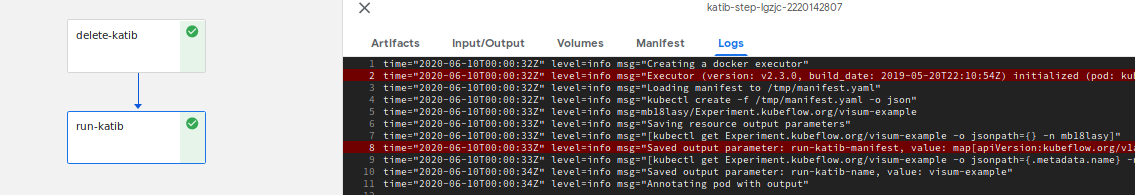

and an additional visualization in the __Katib Dashboard__

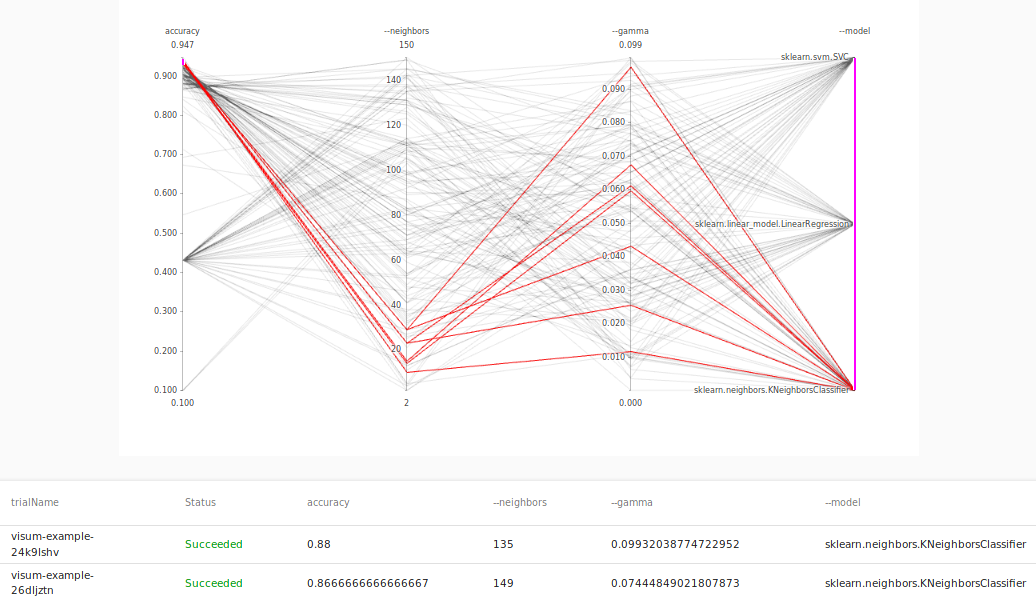

# Model Training
As our __Katib Experiment__ showed, our best bet clearly seems to be a K-Nearest-Neighbors classifier
with an amount of 10 to 40 neighbors. We will later see how to gather that knowledge from within Kubeflows
__Argo Pipelines__ directly. For now, let's train and store the classifier with manually specified parameters.
Additionally, as oposed to the preprocessing and tuning step, we will make use of our ContainerOp wrapper and combine two pipeline steps.

## Code

To train our model we need to:
- gather and store the data
- initialise the model
- train it on a subset (training set) of the data
- store the models (/ the models weights) to load them later

In [76]:
from joblib import dump
import json, dill, os

def train(model: str, out: str, args: str):
    keys = json.loads(args)
    clf_str = model.split(".")[-1]
    lib = model.replace(clf_str, "")[:-1]
    clf = getattr(import_module(lib), clf_str)
    clf = clf(**keys)
    
    with open(os.path.join(out, "folds.pickle"), "rb") as fp:
        folds = dill.load(fp)
    
    X, y = folds[0].train.X, folds[0].train.y
    clf.fit(X.reshape((-1, 8*8)), y)
    dump(clf, os.path.join(out, "clf.pickle"))
    X, y = folds[0].test.X.reshape((-1, 8*8)), folds[0].test.y
    score = clf.score(X, y)
    print("Accuracy: {}".format(score))
    return score

out = "dump"

with open(os.path.join("dump", "folds.pickle"), "wb") as fp:
    dill.dump(cross_folds, fp)
    
args = json.dumps({"n_neighbors": 10})
train("sklearn.neighbors.KNeighborsClassifier", out, args);

Accuracy: 0.94


## Pipeline Step

In [91]:
@pipeline(name="training-step", description="hyperparameter tuning step of the VISUM example")
def pipe():
    # Check if the ressource exists and delete in that case
    
    preprocess, preprocess_outs = container(name="preprocess", 
                                            arguments="python main.py preprocess --out .", 
                                            outputs={"folds": "folds.pickle"})
    
    train, _ = container(name="train", 
                         arguments="python main.py train --out . --model sklearn.neighbors.KNeighborsClassifier --args '{\"n_neighbors\": 10}'", 
                         inputs=[preprocess_outs["folds"]]
                         )
    train.after(preprocess)
    
    
kfp.Client().create_run_from_pipeline_func(pipe, arguments={})

RunPipelineResult(run_id=0a2cc455-4851-4d99-a712-9766738b5306)

Which will create a run that looks as follow

![training](../assets/train_step-2020-06-10_14.54.17.mp4.gif)

# Model Validation

In order to make sure we didn't simply hit on a advantageous dataset for training and our model will deliver
stable results in a long-term scenario we are required to select a representative probe of data for testing. By selecting 
a meaningful testing set we aim to abstract an error function that spans a concave error surface which global minimum 
we are trying to discover with our trained model. Only that way we can ensure, that our model will fit to any data related 
with the given problem. It is, however, a fact that finding such a dataset for testing is not very realistic, as we don't know
ANY data related to the problem. A simple trick that is regularly done is using cross validation, which means to test on random 
subsets of data that have the same percentage of availble classes. We will implement this cross validation and perform it on our
pretrained model. 

## Code

Accuracy: 0.9604960981047936


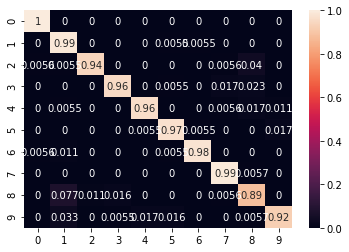

In [81]:
from joblib import load
import seaborn as sn
from sklearn.metrics import confusion_matrix

def validate(out):
    score = 0.
    cnf = np.zeros((10, 10))
    clf = load(os.path.join(out, "clf.pickle"))

    with open("{}/folds.pickle".format(out), "rb") as fp:
        folds = dill.load(fp)

    for ds in folds:
        clf.fit(ds.train.X.reshape(-1, 8 * 8), ds.train.y)
        score += clf.score(ds.test.X.reshape(-1, 8 * 8), ds.test.y)
        predictions = clf.predict(ds.test.X.reshape(-1, 8 * 8))
        cnf += confusion_matrix(ds.test.y, predictions)

    cnf /= len(cnf)
    cnf /= cnf.sum(axis=1)
    sn.heatmap(cnf, annot=True, )
    plt.savefig(os.path.join(out, "conf.svg"))

    cv_score = score / len(folds)
    print("Accuracy: {}".format(cv_score))
    return cv_score

validate(out);

## Pipeline Step
Exactly as with the training step we will use the ContainerOp wrapper and add our validation as next pipeline step.

In [97]:
@pipeline(name="training-step", description="hyperparameter tuning step of the VISUM example")
def pipe(out:str = ""):
    # Check if the ressource exists and delete in that case
    
    preprocess, preprocess_outs = container(name="preprocess", 
                                            arguments="python main.py preprocess --out {}".format(out), 
                                            outputs={"folds": "folds.pickle"})
    
    model = "sklearn.neighbors.KNeighborsClassifier"
    args = json.dumps({"n_neighbors": 20})
    train, train_outs = container(name="train", 
                                  arguments="python main.py train --out {} --model {} --args '{}'".format(out, model, args), 
                                  inputs=[preprocess_outs["folds"]],
                                  outputs={"model": "clf.pickle"}
                                  )
    train.after(preprocess)
    
    valid, _ = container(name="validate", 
                         arguments="python main.py validate --out {}".format(out),
                         inputs=[train_outs["model"], preprocess_outs["folds"]],
                         outputs={"confusion": "conf.svg"}
                         )
    valid.after(train)

kfp.Client().create_run_from_pipeline_func(pipe, arguments={"out": "."})

RunPipelineResult(run_id=e687b9c3-f2a1-4077-9fa7-fbbe6685a89a)

this leads to a pipeline step as below

![validation](../assets/valid_step-2020-06-10_15.06.14.mp4.gif)

# Model Deployment
Now that we have created and validated our model we want to host it as a service that is publically available.
Kubeflow offers two methods for that: 
- Using __Googles KNative__ stack 
- Deploying with __Seldon Core__

As __KNative__ can suffer from incompatibility when used behind an __Istio Gateway__ in a multi-tenancy cluster (as in this case), 
for the ease of implementation let's use Seldon. 

## Code
For a local deployment the Code looks like this (Note that the File name needs to be equal to the Class name in order for seldon to identify the model).

In [103]:
!bat ../src/MnistModel.py

───────┬────────────────────────────────────────────────────────────────────────
       │ File: ../src/MnistModel.py
───────┼────────────────────────────────────────────────────────────────────────
   1   │ from joblib import load
   2   │ 
   3   │ 
   4   │ class MnistModel:
   5   │     def __init__(self):
   6   │         path = "/pv/clf.pickle"
   7   │         self.model = load(path)
   8   │ 
   9   │     def predict(self, x, shape):
  10   │         return self.model.predict(x.reshape(-1, 8 * 8))
───────┴────────────────────────────────────────────────────────────────────────


Now, using the __Openshift Source-To-Image (S2I)__ Tool (https://github.com/openshift/source-to-image), we will build an appropriate server image and run it with docker.

In [48]:
!mkdir build
!echo joblib > build/requirements.txt
!echo scikit-learn >> build/requirements.txt
!cp ../src/MnistModel.py build
!s2i build build -e MODEL_NAME="MnistModel" \
              -e API_TYPE="REST"\
              -e SERVICE_TYPE="MODEL"\
              -e PERSISTENCE=0\
seldonio/seldon-core-s2i-python3:0.18 mbu93/visum-seldon-server:latest
!rm -rf build

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Build completed successfully


In [60]:
!docker run -v $(pwd)/dump:/pv --name "mnist-server" -d --rm\
            -p 5000:5000 mbu93/visum-seldon-server:latest

fb5413d7d31f60ee1079809e7e86b07fc886bc7cbd909c76002c091ef4eede69


Now that our server is deployed, we can send images to the api and will receive a prediction of the referring class

In [61]:
import requests as rq
import json
idx = 0
url = "http://localhost:5000/predict"
data = {"data": {
            "ndarray": cross_folds[0].test.X[idx].reshape(8*8).tolist(), 
            "shape": [8*8]
        }}
label = json.loads(rq.post(url, json=data).text)["data"]["ndarray"][0]
true = cross_folds[0].test.y[idx]
label, true

(0, 0)

In [62]:
!docker container stop mnist-server

mnist-server


## Pipeline Step
As with the Katib step, we will post the __Seldon Deployment__ (which sadly also isn't part of the __Argo Pipelines__ yet) as Kubernetes resource.
This is ok, as we don't need to catch output of the step anyways. __Seldon__ will then setup a prepacked __Sklearn__ model server *Pod* and a *Service* 
that gives us access to the pod. For the whole thing to work we need to store a model on a *Persistent Volume* or *Cloud Storage* (e.g. a __Google Cloud Bucket__).
We will learn how to do so later. For now we'll simply use an example model that is not related to our work up until here.
The resource looks like this:

In [75]:
import yaml
rsrc = """
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: sklearn
spec:
  name: iris-predict
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/iris
      name: classifier
      parameters:
        - name: method
          type: STRING
          value: predict
    name: default
    replicas: 1"""

rsrc = yaml.safe_load(rsrc);

Let's apply the Ressource as ResourceOp

In [76]:
@pipeline(name="seldon-step", description="seldon deployment step of the VISUM example")
def pipe():
    # Check if the ressource exists and delete in that case
    ctr1 = ResourceOp(
        name="delete deployment",
        action="delete",
        k8s_resource=rsrc
    )    
    ctr2 = ResourceOp(
        name="deploy image",
        k8s_resource=rsrc
    ).after(ctr1)
    
kfp.Client().create_run_from_pipeline_func(pipe, arguments={})

RunPipelineResult(run_id=e6a74990-e468-49eb-9b8c-747b477b318e)

![seldon](../assets/seldon-pipe.png)

This gives us a kubernetes pod

In [77]:
!kubectl get seldondeployment -n kubeflow

NAME              AGE
mnist-model-dev   2d22h
sklearn           30s


And a refering service

In [80]:
!kubectl get service -n kubeflow | grep seldon | grep iris-predict

iris-predict-default-classifier-seldonio-sklearnserver-rest-0-2   ClusterIP      10.43.67.31     <none>                                                9000/TCP                            92s


Let's post a request to the service and get a prediction. We'll access the service using an additional gateway server (kong), 
that host's the service publically). This work was done manually in the background and beforehand, so we don't need to bother it.

In [87]:
idx = 0
url = "https://api.mindset-project.de/visum-mnist/api/v1.0/predictions"
data = {"data": {
            "ndarray": cross_folds[0].test.X[idx].reshape(8*8).tolist(), 
            "shape": [8*8]
        }}

rq.post(url, json=data).text

'{\n  "status": {\n    "code": -1,\n    "info": "Unknown data type returned as payload (must be list or np array):None",\n    "reason": "MICROSERVICE_BAD_DATA",\n    "status": "FAILURE"\n  }\n}'

# Putting things together - A complete pipeline
In the previous chapters we have learned how to:
- Use kubernetes to run a parallelised Parameter search for a machine learning model
- Gather and store data within a Kubeflow pipeline on Kubernetes
- Perform Model Training and Validation including saving of the model and artifacts in our cluster
- Deploying a pretrained model

Now let's connect those steps. Our final pipeline will:

-> Download and preprocess our data<br>
-> Find a matching model (out of a predefined model pool as before) to predict the labels and choose useful parameters<br>
-> Train the selected model with the choosen parameters<br>
-> Validate the trained model<br>
-> Deploy the trained model<br>

Our pipelinespec looks like this

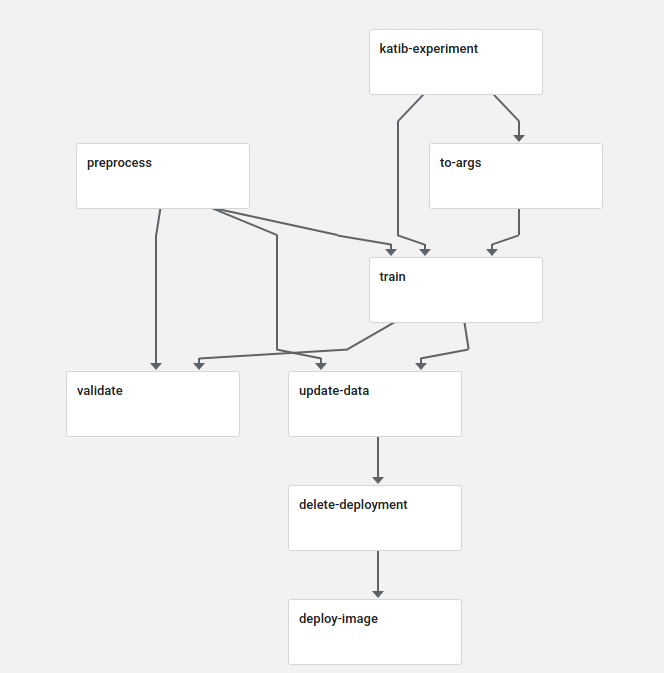

For our Katib step we need an additional container that will return the experiment outputs.

In [3]:
import sys
sys.path.append("../src")

from katib import KatibOp

Additionally we will need a second container to wait for the Experiment results and pass them to the next stage. 
The whole resource will look like this.

In [33]:
from kfp.dsl import PipelineVolume
import yaml, json

#maxTrialCount = 15
#katib_resource = yaml.safe_load(open("../src/katib.yaml", "r").read())
#katib_resource["spec"]["maxTrialCount"]  = maxTrialCount
#katib_resource["spec"]["maxFailedTrialCount"]  = maxTrialCount
katib_resource = KatibOp("docker.io/mbu93/visum-pipeline-runner:latest", 
                         "katib-step", "/out", "", "", "")
seldon_resource = yaml.safe_load(open("../src/seldon.yaml", "r").read())

def to_args(params: str) -> str:
    import json
    from importlib import import_module
    
    # Load the parameters (stored as json string)
    x = json.loads(params)
    args = ""
    model_args = {}
    
    # parse model and get arguments dict
    for entry in x:
        if entry["name"].replace("--", "") in ["out", "model"]:
            model = entry["value"]
            args += "{} {} ".format(entry["name"], entry["value"])
        else:
            model_args[entry["name"].replace("--", "")] = entry["value"]
    
    # load model
    lib = ".".join(model.split(".")[:-1])
    m = model.split(".")[-1]
    m = getattr(import_module(lib), m)
    
    # sort out non available args
    for arg in list(model_args):
        try:
            m(**model_args)
        except Exception:
            del model_args[arg]

    return args + "--args '{}'".format(json.dumps(model_args))

@pipeline(name="katib-step", description="hyperparameter tuning step of the VISUM example")
def pipe():  
    katib, _ = container("katib-experiment", 
                         katib_resource.op, 
                         image=katib_resource.controller_img, 
                         outputs={"params": "results/params"})
    
    args_op = kfp.components.func_to_container_op(to_args, base_image=BASE_IMAGE)
    params = args_op(katib.outputs["params"])
    
    preprocess, preprocess_outs = container(name="preprocess", 
                                        arguments="python main.py preprocess --out .", 
                                        outputs={"folds": "folds.pickle"})

    train, train_outs = container(name="train", 
                         arguments="python main.py train --out . {}".format(params.output), 
                         inputs=[preprocess_outs["folds"]],
                         outputs={"model": "clf.pickle"}
                         )
    train.add_pvolumes({"/pv": PipelineVolume(pvc="pipeline-pv")})
    train.after(preprocess)
    train.after(katib)
    
    valid, _ = container(name="validate", 
                         arguments="python main.py validate --out .",
                         inputs=[train_outs["model"], preprocess_outs["folds"]],
                         outputs={"confusion": "conf.svg"}
                         )
    valid.after(train)
    update_data, _ = container(name="update data", 
                           arguments=dedent("""
                               mkdir -p /pv/models
                               cp -r *.pickle /pv/models
                           """),
                           inputs=[train_outs["model"], preprocess_outs["folds"]])
    update_data.add_pvolumes({"/pv": PipelineVolume(pvc="pipeline-pv")})
    update_data.after(train)
    
    del_depl = ResourceOp(
        name="delete deployment",
        action="delete",
        k8s_resource=seldon_resource
    ).after(update_data)
    depl = ResourceOp(
        name="deploy image",
        k8s_resource=seldon_resource
    ).after(del_depl)
    
kfp.Client().create_run_from_pipeline_func(pipe, arguments={})

RunPipelineResult(run_id=99751598-fb74-42c9-9e0e-d8fbf37f61d1)

It works!
![pipe_full](../assets/pipeline_full.gif)

# Simple DVC example
To get an idea of how DVC works let's set the created data folds as depedency and then run out training with DVC.
For that purpose we will first of all create the folds (__Note__: DVC has already been setup with dvc init. Also note that 
dvc expects to be run inside a Git repository).

In [12]:
!python ../src/main.py preprocess --out dump

Set 0: training images shape: (1497, 8, 8)
Set 0: test images shape: (300, 8, 8)
Set 0: training labels shape: (1497,)
Set 0: test labels shape: (300,)
Set 1: training images shape: (1497, 8, 8)
Set 1: test images shape: (300, 8, 8)
Set 1: training labels shape: (1497,)
Set 1: test labels shape: (300,)
Set 2: training images shape: (1497, 8, 8)
Set 2: test images shape: (300, 8, 8)
Set 2: training labels shape: (1497,)
Set 2: test labels shape: (300,)
Set 3: training images shape: (1498, 8, 8)
Set 3: test images shape: (299, 8, 8)
Set 3: training labels shape: (1498,)
Set 3: test labels shape: (299,)
Set 4: training images shape: (1498, 8, 8)
Set 4: test images shape: (299, 8, 8)
Set 4: training labels shape: (1498,)
Set 4: test labels shape: (299,)
Set 5: training images shape: (1498, 8, 8)
Set 5: test images shape: (299, 8, 8)
Set 5: training labels shape: (1498,)
Set 5: test labels shape: (299,)


In [15]:
!ls -l dump

insgesamt 7140
-rw-r--r-- 1 mbu93 users 1624856 10. Jun 12:51 clf.pickle
-rw-r--r-- 1 mbu93 users   63452 10. Jun 14:14 conf.svg
-rw-r--r-- 1 mbu93 users 5608028 15. Jun 18:13 folds.pickle
-rw-r--r-- 1 mbu93 users    5412 14. Jun 16:35 pipeline.yaml


We will configure a remote that will point to the local folder remote (for demonstration purpose), where such 
a remote typically would be an SSH storgae, Google Cloud Bucket or HDFS system

In [18]:
!rm -rf visum-remote
!mkdir -r visum-remote
!dvc remote add -d myremote ./visum-remote

mkdir: Ungültige Option -- r
„mkdir --help“ liefert weitere Informationen.
Setting 'myremote' as a default remote.


Now we can add our data to the remote

In [23]:
!dvc add dump/folds.pickle
!dvc push

Stage is cached, skipping.                                                      
Adding...
!
Processing                                             0.00 [00:00,     ?file/s]
  0% Add|                                              |0/0 [00:00,     ?file/s]
Everything is up to date.                                                       


In [24]:
!ls visum-remote

b8


To check if this worked we will delete the local folds and run __dvc pull__ to get our data back

In [25]:
!rm dump/folds.pickle
!ls dump
!dvc pull

clf.pickle  conf.svg  folds.pickle.dvc	pipeline.yaml
1 added                                                                         
Everything is up to date.


In [26]:
!ls dump

clf.pickle  conf.svg  folds.pickle  folds.pickle.dvc  pipeline.yaml


Now we run our training (main.py train) as a dvc pipeline as follow

In [44]:
!dvc run -d dump/folds.pickle ../src/main.py train --model "sklearn.svm.SVC" --args {"gamma": 0.01} 

Running command:                                                        
	../src/main.py train --model sklearn.svm.SVC --args {gamma: 0.01}
/home/mbu93/.virtualenvs/visum-talk/bin/python3: No module named virtualfish
Failed to execute process '../src/main.py'. Reason:
exec: Exec format error
The file '../src/main.py' is marked as an executable but could not be run by the operating system.
                                                                        
To track the changes with git, run:

	git add Dvcfile


If we repeat the step dvc will tell us nothing has changed (as the data and the code are still the same) and skip this step

In [45]:
!dvc run -d dump/folds.pickle ../src/main.py train --model "sklearn.svm.SVC" --args {"gamma": 0.01} 

Stage is cached, skipping.                                              


Now well manipulate the folds (their hash sum will change from this). DVC will run the pipeline afterwards

In [53]:
import dill
with open("dump/folds.pickle", "rb") as fp:
    new_folds = dill.load(fp)
new_folds[0].train.y[0] = 0

with open("dump/folds.pickle", "wb") as fp:
    dill.dump(new_folds, fp)

In [55]:
!dvc run --overwrite -d dump/folds.pickle ../src/main.py train --model "sklearn.svm.SVC" --args {"gamma": 0.01} 

Running command:                                                        
	../src/main.py train --model sklearn.svm.SVC --args {gamma: 0.01}

To track the changes with git, run:

	git add Dvcfile


That's it! Now finally by adding the hash files to Git we enable other Contributors of the repo to reproduce 
this exact workflow and stay in sync with our results. Besides that, they can also reproduce older results.
If you wonder how this exactly works, as a last tiny thing let's have a look to the remote, the cache and the dvc training file

In [56]:
!tree ../.dvc/cache

../.dvc/cache
└── b8
    └── 0c9e90644a7bd0f661dd6de874e810

1 directory, 1 file


In [57]:
!tree visum-remote/

visum-remote/
└── b8
    └── 0c9e90644a7bd0f661dd6de874e810

1 directory, 1 file
